# Convolutional Neural Networks

The fully connected neural network we looked at in the previous lesson takes in a vector as input thus a flattened image could be passed in as input and used for classification problems successfully. But this is not the best way to do it. When trying to interpret an image, the spatial relations between the different pixels is crucial to our understanding. When we flatten the image, we lose this information.

Convolutional neural networks solve this very problem. Rather than performing a matrix multiplication, a convolution operation is performed which can take in a 2d input and give a 2d output hence keep the information about the spatial relations of the pixels. This greatly increases their performance on image and video processing tasks.

In the convolution proccess, you have a filter which you start on the top left side of the image and slide across the whole image, taking a dot product between the values of the filter and pixel values of the image. Bear in mind that colour images have three colour channels so your filter may be 3d so you take the dot product across a 3d volume. Each dot product corresponds to a single activation value in a 2d matrix of neurons which corresponds to a single layer in the output.

![image](images/CNN_RGB.JPG)

The animation below shows how a 1x3x3 filter is applied to a 1x5x5 image. Notice how the output has high  values when the filter is passed over locations where there is an X shape in the input image. This is because the values of the filter are such that it is performing pattern matching for the X shape.

![image](images/convolution_animation.gif)

Convolution operations have 3 parameters, the kernel size, which is the width and height of our filter, the stride, which is the number of pixels we translate our kernel by to compute the next feature, and the padding which is how many layers of 0 padding we add to the input image. We som

![image](images/CNN_diagram.JPG)

Each computed feature is a linear function of the pixels in a local region as opposed to fully connected nets where each computed feature is a linear function of all the pixels in the image.

We have some prior understanding of how image data should be processed. We apply the same set of weights at different locations all over the image because we know that features are repeated at different locations throughout the image. This makes the learned features translation invariant.


![image](images/CNN_FNN_comparison.JPG)


For a long time, operations like this were used in computer vision to find different patterns in images with the engineers having to manually tune the values of the filters to perform the required function. The only difference now is that we apply an activation such as Relu or Sigmoid at each layer and after setting up the structure of the network, we initialize the filter values randomly before using gradient descent to automatically tune the values of the filters. We can also apply max pooling operations to subsample the output at each layer therefore reducing the number of parameters that need to be learned for the succeeding convolution operation.


Just like before, each layer in the whole network learns higher level abstract features from the inputs.

In [107]:
import torch
from torchvision import datasets, transforms

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=transforms.ToTensor(),          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=transforms.ToTensor(),
                           train=False,
                          )

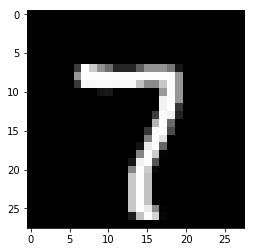

In [108]:
import matplotlib.pyplot as plt
import numpy as np
x = train_data[np.random.randint(0, 300)][0]    # get a random example
#print(x)
plt.imshow(x[0].numpy(),cmap='gray')
plt.show()

In [109]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation

In [110]:
batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

In [111]:
import torch.nn.functional as F
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
            # torch.nn.conv2d(in_channels, out_channels, kernel_size)
            # in_channels is the number of layers which it takes in (i.e.num color channels in 1st layer)
            # out_channels is the number of different filters that we use
            # kernel_size is the depthxwidthxheight of the kernel#
            # stride is how many pixels we shift the kernel by each time

    def forward(self, x):
        return x

In [ ]:
learning_rate = 0.0005 # set learning rate
epochs = 5# set number of epochs

cnn = 
criterion = 
optimiser = 

# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter() # we will use this to show our models performance on a graph

In [114]:
def train(model, epochs):
    for epoch in range(epochs):
        for idx, (inputs, labels) in enumerate(train_loader):
            ## get x, y from data
            
            # pass x through your model to get a prediction
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the cost
            if verbose: print('Epoch:', epoch, '\tBatch:', idx, '\tLoss:', loss.item())
            
            optimiser.zero_grad()                  # reset the gradients attribute of all of the model's params to zero
            loss.backward()                        # backward pass to compute and store all of the model's param's gradients
            optimiser.step()                       # update the model's parameters
            
            writer.add_scalar(tag, loss, epoch*len(train_loader) + idx)    # write loss to a graph
    print('Training Complete. Final loss =',loss.item())

In [ ]:
train(cnn, epochs)

In [116]:
import numpy as np
            
def calc_accuracy(model, dataloader):
    num_correct = 0
    num_examples = len(dataloader.dataset)                       # test DATA not test LOADER
    for inputs, labels in dataloader:                  # for all exampls, over all mini-batches in the test dataset
        predictions = model(inputs)
        predictions = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
        predictions = predictions[1]                    # torch.max returns (values, indices)
        num_correct += int(sum(predictions == labels))
    percent_correct = num_correct / num_examples * 100
    return percent_correct

In [117]:
print('Train Accuracy:', calc_accuracy(cnn, train_loader))
print('Validation Accuracy:', calc_accuracy(cnn, val_loader))
print('Test Accuracy:', calc_accuracy(cnn, test_loader))

Train Accuracy: 98.574
Validation Accuracy: 98.11999999999999
Test Accuracy: 98.24000000000001


## Empirical Benchmarking of Fully Connected vs Convolutional Architecture on MNIST

Lets empirically test the translation invariance of the two architectures. 

The training set now has a center crop transformation which crops the central pixels of the image to a given size. However, the test set has a random crop transformation which crops a random region of the image to a given size.

So we are training the neural networks with a centrally cropped image but testing it on cropped images with translations applied.

The network that has more translation invariant features should performs better on this test set.

In [92]:
import torch
from torchvision import datasets, transforms

crop_size = 22

traintransforms = []
traintransforms.append(transforms.##write here)
traintransforms.append(transforms.##)
traintransforms = transforms.Compose(traintransforms)

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=traintransforms,          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

testtransforms = []
testtransforms.append(transforms.##write here)
testtransforms.append(transforms.##)
testtransforms = transforms.Compose(testtransforms)

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=testtransforms,
                           train=False,
                          )

Train Example


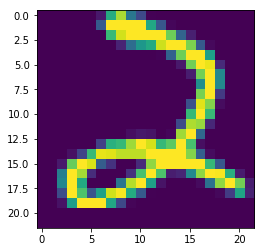

Test Example


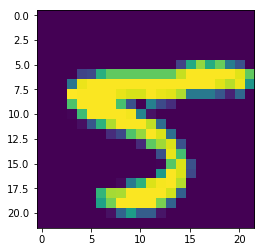

In [93]:
import matplotlib.pyplot as plt
import numpy as np
# PRINT THEIR LENGTHS AND VISUALISE AN EXAMPLE
x = train_data[np.random.randint(0, len(train_data))][0]    # get a random training example
print('Train Example')
plt.imshow(x[0].numpy())
plt.show()
x = test_data[np.random.randint(0, len(test_data))][0]    # get a random test example
print('Test Example')
plt.imshow(x[0].numpy())
plt.show()

In [94]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation

In [95]:
batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

We define the architectures of our fully connected and convolutional networks as well as a function which returns the number of parameters in each model. Since the number of parameters in a model is a rough measure of its capacity, the networks should have an approximately equal number of parameters to make it a fair comparison.

In [102]:
import torch.nn.functional as F 

class FullyConnectedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()    # initialise parent module
        self.fc_layers = torch.nn.Sequential(
            ##
        )
    def forward(self, x):
        x = x.view(-1, crop_size*crop_size)
        x = self.fc_layers(x)
        x = F.softmax(x, dim=1)
        return x
    
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = torch.nn.Sequential( # put your convolutional architecture here using torch.nn.Sequential 
            ##
        )
        self.fc_layers = torch.nn.Sequential(
            ##
            
        )
    def forward(self, x):
        x = self.conv_layers(x)# pass through conv layers
        x = x.view(x.shape[0], -1)# flatten output ready for fully connected layer
        x = self.fc_layers(x)# pass through fully connected layer
        x = F.softmax(x, dim=1)# softmax activation function on outputs
        return x

def get_n_params(model):
    #model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    #n_params = sum([np.prod(p.size()) for p in model_parameters])
    return n_params

In [103]:
learning_rate = 0.0005 # set learning rate
epochs = 5 # set number of epochs
# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter() # we will use this to show our models performance on a graph

In [104]:
cnn = ConvNet().to(device)#instantiate model
print('Number of parameters in cnn:', get_n_params(cnn))
criterion = torch.nn.CrossEntropyLoss() #use cross entropy loss function
optimiser = torch.optim.Adam(cnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate
train(##)

Number of parameters in cnn: 128522
Training Complete. Final loss = 1.4745460748672485


In [105]:
fnn = FullyConnectedNet().to(device)
print('Number of parameters in fnn:', get_n_params(fnn))
optimiser = torch.optim.Adam(fnn.parameters(), lr=learning_rate) # use Adam optimizer, passing it the parameters of your model and the learning rate
train(##)

Number of parameters in fnn: 137285
Training Complete. Final loss = 1.5748454332351685


In [106]:
print('CNN Train Accuracy:', calc_accuracy(cnn, train_loader))
print('CNN Validation Accuracy:', calc_accuracy(cnn, val_loader))
print('CNN Test Accuracy:', calc_accuracy(cnn, test_loader), '\n')

print('FNN Train Accuracy:', calc_accuracy(fnn, train_loader))
print('FNN Validation Accuracy:', calc_accuracy(fnn, val_loader))
print('FNN Test Accuracy:', calc_accuracy(fnn, test_loader))

CNN Train Accuracy: 97.932
CNN Validation Accuracy: 97.50999999999999
CNN Test Accuracy: 71.98 

FNN Train Accuracy: 87.044
FNN Validation Accuracy: 86.3
FNN Test Accuracy: 46.87


As we can see above, there is a significant disparity between the test accuracy of the two architectures, with the CNN have ~+20% test accuracy